In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import *

In [3]:
!pwd

/home/jupyter/Age-Detection-of-Indian-Actors


### Loading the data

The following `fast.ai` function:
- loads the data from the specified folder
- gets the labels from the accompanying .csv file
- apply all the transformations for data augmentation
- prepares the validation set
- resizes the images to (64,64)
- prepares a mini-batch of 32 for training

Wuh! That was neat! 

In [3]:
path = '/home/jupyter/Age-Detection-of-Indian-Actors/Train'
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(flip_vert=True), valid_pct=0.2, csv_labels='train.csv',
                                   size=(64), bs=32).normalize(imagenet_stats)

### Looking at the data in the right way

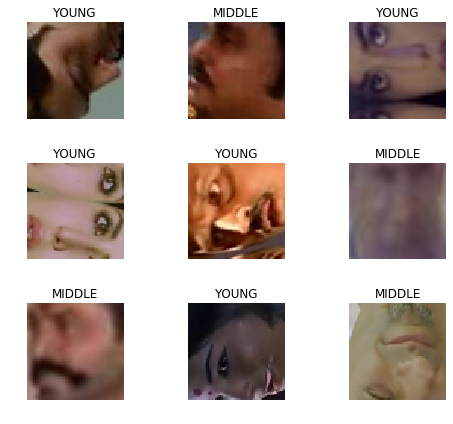

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

['MIDDLE', 'OLD', 'YOUNG']


(3, 3)

### Start of modeling with a pre-trained ResNet50

In [5]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Leslie Smith's learning rate finder technique as discussed in: https://arxiv.org/abs/1506.01186 (incoporated in a library)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


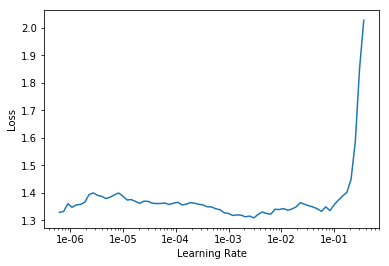

In [12]:
learn.lr_find()
learn.recorder.plot()

### Training for 10 epochs using the _one cycle policy_ introduced by Leslie Smith

In [6]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.967604,0.880178,0.622205,00:30
1,0.886742,0.834942,0.626727,00:26
2,0.842076,0.801205,0.632002,00:26
3,0.793579,0.726939,0.681989,00:26
4,0.775391,0.708506,0.699824,00:26
5,0.729757,0.681233,0.708867,00:26
6,0.715616,0.659954,0.717156,00:26
7,0.677015,0.643384,0.724692,00:26
8,0.717772,0.642674,0.729967,00:25
9,0.677440,0.641219,0.724943,00:26


### Saving the model for later use

In [7]:
learn.save('stage-1-rn50')

### Getting to know where our model is getting confused the most

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

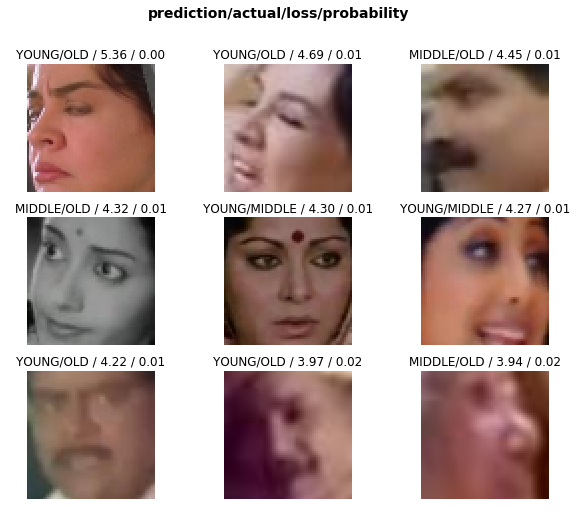

In [19]:
interp.plot_top_losses(9, figsize=(10,8))

The data has some nuances: 
- Unclear images
- BW images are getting classified as old-aged because of color tone
- The sixth image from the above plot is not even a middle-aged person. Seemingly, it is YOUNG. 

### A bit more model training with 5 epochs and differential learning rates (`max_lr`)

In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-5/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.703999,0.645463,0.719668,00:40
1,0.691176,0.631474,0.725948,00:39
2,0.678279,0.619522,0.732982,00:40
3,0.650883,0.618962,0.734740,00:39
4,0.690269,0.620420,0.725446,00:39


### Combining the earlier model weights plus this one

In [ ]:
learn.load('stage-1-rn50')

In [9]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-5/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.668594,0.637032,0.730972,00:39
1,0.705340,0.622179,0.735996,00:39
2,0.674176,0.610719,0.747048,00:39
3,0.644824,0.605969,0.743783,00:39
4,0.654270,0.602834,0.747048,00:39


We are improving. Why not more improvement? Let's go for 20 epochs this time. 

In [10]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-5/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.660522,0.604261,0.744537,00:39
1,0.631226,0.600565,0.747802,00:39
2,0.662187,0.597377,0.747551,00:39
3,0.640959,0.591848,0.749309,00:39
4,0.629227,0.581293,0.752826,00:39
5,0.614742,0.568451,0.763878,00:39
6,0.617807,0.559418,0.770409,00:39
7,0.600641,0.552068,0.774680,00:39
8,0.583909,0.547750,0.775182,00:39
9,0.591583,0.538424,0.779452,00:39


We have a good improvement. Let's save the model weights.

In [11]:
learn.save('stage-2-rn50')

### Experimenting with other learning rate ranges (and failing)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-2,1e-2/5))

![](https://i.ibb.co/chw3hkb/Capture.png)

Loss and accuracy very poor. 

### Combining the latest decent model weights + a bit more training

In [12]:
learn.load('stage-2-rn50')
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-5/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.547569,0.512532,0.793519,00:39
1,0.551288,0.513655,0.790003,00:39
2,0.555731,0.510320,0.791761,00:39
3,0.561045,0.508554,0.793017,00:39
4,0.534382,0.498175,0.805577,00:39
5,0.521911,0.488860,0.810349,00:39
6,0.521292,0.487308,0.810852,00:39
7,0.526594,0.485010,0.810098,00:39
8,0.527018,0.484116,0.810098,00:39
9,0.507124,0.485838,0.809344,00:39


A clear bump in the accuracy. Let's save the weights. Let's see how our model is doing on a few test samples. 

In [13]:
learn.save('stage-3-rn50')

### Using the model for inferencing

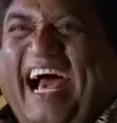

In [9]:
img1 = open_image('/home/jupyter/Age Detection Challenge/Age-Detection-of-Indian-Actors/Test/54.jpg')
img1

In [10]:
pred_class,pred_idx,outputs = learn.predict(img1)
pred_class

Category MIDDLE

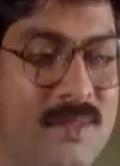

In [12]:
img2 = open_image('/home/jupyter/Age Detection Challenge/Age-Detection-of-Indian-Actors/Test/10066.jpg')
img2

In [13]:
pred_class,pred_idx,outputs = learn.predict(img2)
pred_class

Category MIDDLE

> Not bad, huh! 

### Let's predict on the entire test set and submit: Submission 01

In [17]:
import pandas as pd
import os
labels = []

test_csv = pd.read_csv('/home/jupyter/Age-Detection-of-Indian-Actors/sub/sub02.csv')

for img_name in test_csv.ID:
    img_path = os.path.join('/home/jupyter/Age-Detection-of-Indian-Actors', 'Test', img_name)
    img = open_image(img_path)
    pred_class, _, _ = learn.predict(img)
    labels.append(pred_class)

In [26]:
labels = list(map(lambda x: str(x).replace('Category', ''), labels))

In [30]:
test_csv['Class'] = labels
test_csv.to_csv('/home/jupyter/Age-Detection-of-Indian-Actors/sub/submission_sayak_fastai.csv', index=False)

In [29]:
!head -5 submission_sayak_fastai.csv

ID,Class
25321.jpg,YOUNG
989.jpg,YOUNG
19277.jpg,MIDDLE
13093.jpg,MIDDLE


### Cleaning our data

Now, we will clean some of the images (which suffer from the previously-mentioned issues) from the dataset.  

In [ ]:
# To get the widgets working
#!sudo jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [15]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [16]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(flip_vert=True), valid_pct=0.2, csv_labels='cleaned.csv',
                                   size=(64), bs=32).normalize(imagenet_stats)

In [ ]:
learn.load('stage-3-rn50')

In [24]:
learn.data = data
learn.unfreeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.653840,0.698799,0.706529,00:31
1,0.744350,0.677732,0.715631,00:31
2,0.696318,0.627105,0.741055,00:31
3,0.600401,0.527785,0.775895,00:32
4,0.529197,0.488008,0.805085,00:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


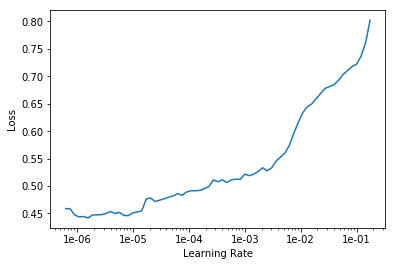

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(10, max_lr=slice(1e-04, 1e-04/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.506807,0.479924,0.808537,00:32
1,0.521768,0.488088,0.795982,00:32
2,0.534796,0.475229,0.804771,00:32
3,0.500347,0.479918,0.802888,00:32
4,0.479075,0.458360,0.812618,00:31
5,0.453072,0.437076,0.822348,00:31
6,0.434572,0.427873,0.832078,00:31
7,0.394721,0.411138,0.835530,00:32
8,0.383188,0.405780,0.838983,00:32
9,0.399199,0.409233,0.839297,00:32


In [29]:
learn.save('stage-4-rn50')

Look at the imporvement <3

**Looking for duplicates** - 

In [27]:
ds, idxs = DatasetFormatter().from_similars(learn)

Getting activations...


Computing similarities...


In [28]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [4]:
# No validation set this time: Train on train + valid
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(flip_vert=True), valid_pct=0., csv_labels='cleaned.csv',
                                   size=(64), bs=32).normalize(imagenet_stats)

In [6]:
learn.load('stage-4-rn50')
learn.unfreeze()
learn.fit_one_cycle(5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


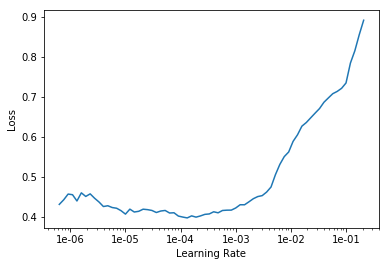

In [7]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(5, max_lr=slice(1e-05, 1e-05/5))

In [9]:
learn.save('stage-5-rn50')
learn.export('/home/jupyter/Age-Detection-of-Indian-Actors/age-model.pkl')

### Submission 02

In [34]:
import pandas as pd
import os
labels = []

test_csv = pd.read_csv('/home/jupyter/Age-Detection-of-Indian-Actors/sub/sub02.csv')

for img_name in test_csv.ID:
    img_path = os.path.join('/home/jupyter/Age-Detection-of-Indian-Actors', 'Test', img_name)
    img = open_image(img_path)
    pred_class, _, _ = learn.predict(img)
    labels.append(pred_class)
    
labels = list(map(lambda x: str(x).replace('Category', ''), labels))
test_csv['Class'] = labels
test_csv.to_csv('/home/jupyter/Age-Detection-of-Indian-Actors/sub/submission_sayak_fastai.csv', index=False)

In [36]:
!head -5 /home/jupyter/Age-Detection-of-Indian-Actors/sub/submission_sayak_fastai.csv

ID,Class
25321.jpg,MIDDLE
989.jpg,YOUNG
19277.jpg,YOUNG
13093.jpg,MIDDLE
